In [2]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim


from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from torchvision.datasets import ImageFolder
from tqdm import tqdm   # show loops progress

#import wandb    # track and visualize aspects of training proccess in real time
#import evaluate
from unet import UNet
#from utils.data_loading import BasicDataset, CarvanaDataset
from utils.dice_score import dice_loss

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


**Carga de datos de entrenamiento**

In [4]:
# Dataset personalizado para DRIVE
class DriveDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))  # Ordenar para emparejar correctamente
        self.mask_filenames = sorted(os.listdir(mask_dir))    # Ordenar para emparejar correctamente
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convertir a escala de grises para las máscaras
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transformaciones para las imágenes y las máscaras
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Ajusta según tus necesidades
    transforms.ToTensor()
])

# Routes
image_dir = './data/DRIVE/training/images'
gt_dir = './data/DRIVE/training/1st_manual'
#dir_checkpoint = Path('./checkpoints/')        # donde se guardarán

dataset = DriveDataset(image_dir, gt_dir, transform=transform)

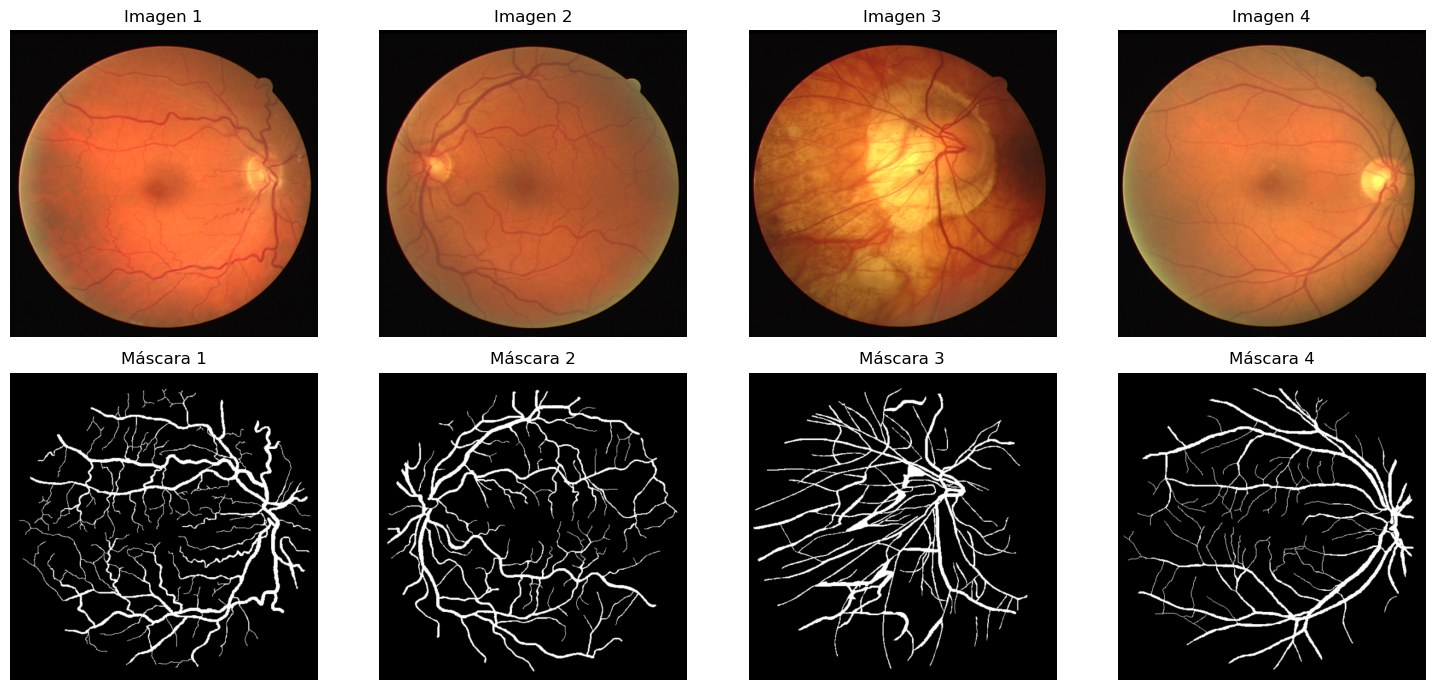

In [5]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, masks = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
masks = masks.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
masks = np.squeeze(masks)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Imagen {i+1}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(masks[i], cmap='gray')  # Usar escala de grises para las máscaras
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Máscara {i+1}')

plt.tight_layout()
plt.show()

In [6]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(0))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [7]:
sample_image, sample_label = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_label.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


In [8]:
EPOCHS:int = 100
LEARNING_RATE:float = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")

device.type='cuda'


In [9]:
from unet import UNet
model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
model.to(device)      # move to cuda if possible

SAVE_PATH = "./trained_models"

In [10]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [11]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path):
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        for data in tqdm(train_dataloader):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            loss = loss_fn(pred, mask)
            running_train_loss += loss.item()
            loss.backward()    # calculate gradients
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            for data in tqdm(val_dataloader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                loss = loss_fn(pred, mask)
                running_val_loss += loss.item()

        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss}')
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state

    # Save the best model state
    if best_model_state is not None:
        model_path = save_path+'/'+'model_{}_{}'.format(type(model).__name__, datetime.now().strftime('%Y%m%d_%H%M%S'))
        torch.save(best_model_state, model_path)
        print(f'\nBest model saved at {model_path}')
    
    model.eval()
    return history

In [12]:
history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH)

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch: 1/100 | Training loss: 0.14214714989066124 | Validation loss: 0.17181603610515594


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Epoch: 2/100 | Training loss: 0.1335836686193943 | Validation loss: 0.16654951870441437


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Epoch: 3/100 | Training loss: 0.1238190308213234 | Validation loss: 0.15972162783145905


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 4/100 | Training loss: 0.11457061395049095 | Validation loss: 0.15163926780223846


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Epoch: 5/100 | Training loss: 0.1066886056214571 | Validation loss: 0.1428391933441162


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Epoch: 6/100 | Training loss: 0.0998204592615366 | Validation loss: 0.13403066992759705


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch: 7/100 | Training loss: 0.09360125474631786 | Validation loss: 0.12639111280441284


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 8/100 | Training loss: 0.08796841837465763 | Validation loss: 0.12009099125862122


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Epoch: 9/100 | Training loss: 0.08426093123853207 | Validation loss: 0.11484275758266449


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch: 10/100 | Training loss: 0.08038220927119255 | Validation loss: 0.10906228423118591


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch: 11/100 | Training loss: 0.07792656309902668 | Validation loss: 0.10251228511333466


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 12/100 | Training loss: 0.07463104091584682 | Validation loss: 0.09523458778858185


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 13/100 | Training loss: 0.07259667478501797 | Validation loss: 0.08853787183761597


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 14/100 | Training loss: 0.07034611329436302 | Validation loss: 0.0826515257358551


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 15/100 | Training loss: 0.0685596689581871 | Validation loss: 0.07764256000518799


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 16/100 | Training loss: 0.06689364090561867 | Validation loss: 0.07370606064796448


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 17/100 | Training loss: 0.06574131548404694 | Validation loss: 0.07049833983182907


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch: 18/100 | Training loss: 0.06453795172274113 | Validation loss: 0.06800393760204315


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 19/100 | Training loss: 0.06318922620266676 | Validation loss: 0.06576362252235413


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 20/100 | Training loss: 0.06191655341535807 | Validation loss: 0.06431671977043152


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 21/100 | Training loss: 0.06110484339296818 | Validation loss: 0.06320972740650177


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch: 22/100 | Training loss: 0.059724568389356136 | Validation loss: 0.06316645443439484


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 23/100 | Training loss: 0.05832016281783581 | Validation loss: 0.06227511912584305


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 24/100 | Training loss: 0.05750570259988308 | Validation loss: 0.060953475534915924


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 25/100 | Training loss: 0.056533911265432835 | Validation loss: 0.06072498857975006


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 26/100 | Training loss: 0.05577859189361334 | Validation loss: 0.05848998576402664


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 27/100 | Training loss: 0.05453769490122795 | Validation loss: 0.058951087296009064


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 28/100 | Training loss: 0.05359654128551483 | Validation loss: 0.05719109624624252


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 29/100 | Training loss: 0.053006826899945736 | Validation loss: 0.0552092082798481


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch: 30/100 | Training loss: 0.052095936611294746 | Validation loss: 0.0543648861348629


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch: 31/100 | Training loss: 0.05150558799505234 | Validation loss: 0.0619925782084465


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Epoch: 32/100 | Training loss: 0.05042737256735563 | Validation loss: 0.05332236737012863


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 33/100 | Training loss: 0.05052273906767368 | Validation loss: 0.05492711067199707


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 34/100 | Training loss: 0.049412370659410954 | Validation loss: 0.057807646691799164


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 35/100 | Training loss: 0.048905787989497185 | Validation loss: 0.05044185370206833


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 36/100 | Training loss: 0.04739773739129305 | Validation loss: 0.053128138184547424


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Epoch: 37/100 | Training loss: 0.04686590936034918 | Validation loss: 0.047557149082422256


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 38/100 | Training loss: 0.04686262831091881 | Validation loss: 0.048489127308130264


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 39/100 | Training loss: 0.04624933935701847 | Validation loss: 0.04900459200143814


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 40/100 | Training loss: 0.04537669103592634 | Validation loss: 0.04559041187167168


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 41/100 | Training loss: 0.04530779551714659 | Validation loss: 0.049477994441986084


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Epoch: 42/100 | Training loss: 0.04455427639186382 | Validation loss: 0.044092390686273575


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 43/100 | Training loss: 0.043858264572918415 | Validation loss: 0.04497293382883072


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 44/100 | Training loss: 0.043851486407220364 | Validation loss: 0.04541033133864403


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 45/100 | Training loss: 0.042967602610588074 | Validation loss: 0.04351990297436714


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 46/100 | Training loss: 0.04289811011403799 | Validation loss: 0.053912654519081116


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 47/100 | Training loss: 0.04291283246129751 | Validation loss: 0.04165148735046387


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 48/100 | Training loss: 0.042190336622297764 | Validation loss: 0.05326111242175102


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 49/100 | Training loss: 0.04135537054389715 | Validation loss: 0.042174242436885834


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Epoch: 50/100 | Training loss: 0.041100929491221905 | Validation loss: 0.042733028531074524


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 51/100 | Training loss: 0.040970949456095695 | Validation loss: 0.04538740962743759


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 52/100 | Training loss: 0.039821185171604156 | Validation loss: 0.040430307388305664


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 53/100 | Training loss: 0.03980063181370497 | Validation loss: 0.040750231593847275


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 54/100 | Training loss: 0.03922965470701456 | Validation loss: 0.040164366364479065


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 55/100 | Training loss: 0.03928247280418873 | Validation loss: 0.046211518347263336


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Epoch: 56/100 | Training loss: 0.03937929216772318 | Validation loss: 0.039562299847602844


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 57/100 | Training loss: 0.038233025930821896 | Validation loss: 0.039189040660858154


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Epoch: 58/100 | Training loss: 0.03860106226056814 | Validation loss: 0.05821535736322403


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 59/100 | Training loss: 0.03858082927763462 | Validation loss: 0.03716501593589783


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Epoch: 60/100 | Training loss: 0.03926206659525633 | Validation loss: 0.03776692971587181


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Epoch: 61/100 | Training loss: 0.03778546117246151 | Validation loss: 0.04809746891260147


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Epoch: 62/100 | Training loss: 0.03771376609802246 | Validation loss: 0.03749438747763634


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Epoch: 63/100 | Training loss: 0.038087653927505016 | Validation loss: 0.043620236217975616


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 64/100 | Training loss: 0.03709597419947386 | Validation loss: 0.03594204783439636


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 65/100 | Training loss: 0.03671679273247719 | Validation loss: 0.036259714514017105


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Epoch: 66/100 | Training loss: 0.036348629742860794 | Validation loss: 0.036744263023138046


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 67/100 | Training loss: 0.03654168825596571 | Validation loss: 0.03736770153045654


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 68/100 | Training loss: 0.03632254060357809 | Validation loss: 0.03625323623418808


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Epoch: 69/100 | Training loss: 0.036316970363259315 | Validation loss: 0.054299358278512955


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 70/100 | Training loss: 0.03563169855624437 | Validation loss: 0.0343923456966877


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch: 71/100 | Training loss: 0.0357104130089283 | Validation loss: 0.034550756216049194


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Epoch: 72/100 | Training loss: 0.035704595036804676 | Validation loss: 0.03658585995435715


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Epoch: 73/100 | Training loss: 0.03538069315254688 | Validation loss: 0.035165078938007355


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 74/100 | Training loss: 0.035453079268336296 | Validation loss: 0.05056677386164665


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Epoch: 75/100 | Training loss: 0.035332806408405304 | Validation loss: 0.03441918268799782


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 76/100 | Training loss: 0.03481315169483423 | Validation loss: 0.03463350981473923


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Epoch: 77/100 | Training loss: 0.03495622146874666 | Validation loss: 0.05022960901260376


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 78/100 | Training loss: 0.034291612915694714 | Validation loss: 0.033730439841747284


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 79/100 | Training loss: 0.03497001528739929 | Validation loss: 0.0333995521068573


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 80/100 | Training loss: 0.03455436788499355 | Validation loss: 0.03587611764669418


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Epoch: 81/100 | Training loss: 0.034050675109028816 | Validation loss: 0.03327678516507149


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 82/100 | Training loss: 0.034623689483851194 | Validation loss: 0.0384238101541996


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 83/100 | Training loss: 0.03417153377085924 | Validation loss: 0.03291723132133484


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 84/100 | Training loss: 0.033821838442236185 | Validation loss: 0.033749788999557495


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 85/100 | Training loss: 0.03345570806413889 | Validation loss: 0.032600779086351395


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch: 86/100 | Training loss: 0.03423323296010494 | Validation loss: 0.03385206311941147


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 87/100 | Training loss: 0.03340956661850214 | Validation loss: 0.03706354647874832


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 88/100 | Training loss: 0.03368551842868328 | Validation loss: 0.0330950953066349


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 89/100 | Training loss: 0.03401624225080013 | Validation loss: 0.03274047002196312


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch: 90/100 | Training loss: 0.03343566879630089 | Validation loss: 0.04446418583393097


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch: 91/100 | Training loss: 0.03318025544285774 | Validation loss: 0.031832464039325714


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Epoch: 92/100 | Training loss: 0.03329547680914402 | Validation loss: 0.032550692558288574


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch: 93/100 | Training loss: 0.03299516858533025 | Validation loss: 0.03236232325434685


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch: 94/100 | Training loss: 0.032936941366642714 | Validation loss: 0.03455626964569092


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 95/100 | Training loss: 0.03290323168039322 | Validation loss: 0.036014050245285034


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch: 96/100 | Training loss: 0.032949773129075766 | Validation loss: 0.031556904315948486


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 97/100 | Training loss: 0.032851751428097486 | Validation loss: 0.031217122450470924


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Epoch: 98/100 | Training loss: 0.03244340978562832 | Validation loss: 0.03332152217626572


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Epoch: 99/100 | Training loss: 0.032888226211071014 | Validation loss: 0.030981337651610374


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Epoch: 100/100 | Training loss: 0.032948690466582775 | Validation loss: 0.030921291559934616

Best model saved at ./trained_models/model_UNet_20250118_230539


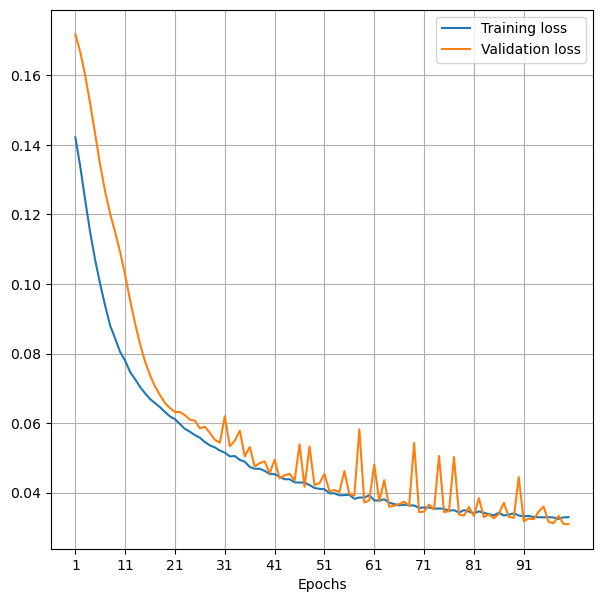

In [13]:
plt.figure(figsize=(7, 7))
plt.plot(np.arange(1,EPOCHS+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1,EPOCHS+1), history['val_loss'], label='Validation loss')
interval = 10 
plt.xticks(np.arange(1, EPOCHS + 1, interval))
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [14]:
model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
model.load_state_dict(torch.load('./trained_models/model_UNet_20250118_220040'))
model.to(device)
model.eval()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2336\3111319290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./trained_models/model_UN

UNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, e

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]  # return image and its name

# load test images
test_dir = './data/DRIVE/test/images'
test_dataset = TestDataset(test_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

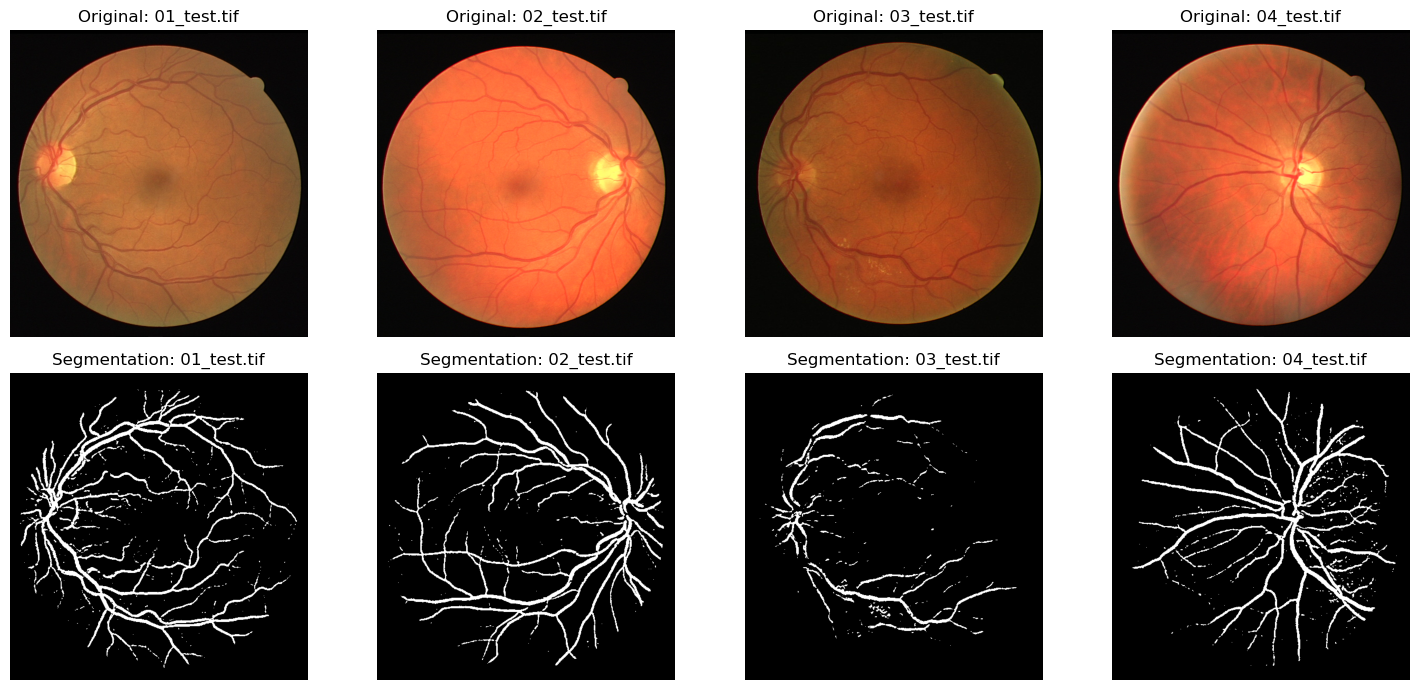

In [26]:
num_images = 4  # number of images to show
fig, axes = plt.subplots(2, num_images, figsize=(15, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output = torch.sigmoid(output)  # apply sigmoid if mask binary
        output = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output.squeeze().cpu().numpy()  # delete batch dimension

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")

        # test images predicted segmentations
        axes[1, i].imshow(output_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

In [38]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(train_loader) instead of
    # iter(train_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):        # each data is a batch
        # Every data instance is an input + label pair
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        print("\n")
        print(labels.min(), labels.max())
        print(outputs.shape)  # Asegúrate que tiene la forma correcta
        print(labels.shape)   # Deben coincidir con outputs
        print(outputs[0])     # Muestra algunas salidas de las predicciones
        

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/UNet/DRIVE_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [14]:
def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    
    # 2. 
    
    
    
    # Crear DataLoaders para entrenamiento y validación
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    


    
    
    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum)  # foreach=True not supported
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0
    
    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
            
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')

    